In [1]:
# # for colab:
# from getpass import getpass
# import os

# user = getpass(' github user ')
# password = getpass(' password ')
# os.environ['AUTH'] = user + ':' + password
# !git clone https://$AUTH@github.com/HSE-LAMBDA/Tomography4DESY-2020.git

# import sys
# sys.path.append('Tomography4DESY-2020')
# ! bash Tomography4DESY\-2020/env.sh

In [ ]:
!wget "https://drive.google.com/uc?export=download&id=1t8j05bsMHEam4qhqPD61hekcD_O7JZ9U" -O offset_shift.mat
!wget "https://drive.google.com/uc?export=download&id=1lf7WERvhOUjip-cV6uDTvBfsmkdmEs99" -O angles.mat
!wget "https://drive.google.com/uc?export=download&id=1zvbaP6jOATj9HXXCHD7zRybVCzhdoIhI" -O sino_000397.tif

--2020-03-08 12:58:00--  https://drive.google.com/uc?export=download&id=1t8j05bsMHEam4qhqPD61hekcD_O7JZ9U
Resolving drive.google.com (drive.google.com)... 74.125.204.100, 74.125.204.101, 74.125.204.138, ...
Connecting to drive.google.com (drive.google.com)|74.125.204.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6s20mhs2h09tqi6d252dm193d0ku1v91/1583672250000/12212386738800444151/*/1t8j05bsMHEam4qhqPD61hekcD_O7JZ9U?e=download [following]
--2020-03-08 12:58:01--  https://doc-04-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6s20mhs2h09tqi6d252dm193d0ku1v91/1583672250000/12212386738800444151/*/1t8j05bsMHEam4qhqPD61hekcD_O7JZ9U?e=download
Resolving doc-04-ag-docs.googleusercontent.com (doc-04-ag-docs.googleusercontent.com)... 108.177.125.132, 2404:6800:4008:c01::84
Connecting to doc-04-ag-docs.googleusercontent.com (doc-0

In [ ]:
from reconstruct import get_from_mat, correct_image, iradon_centered, find_visual_best
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
angles = get_from_mat("angles.mat")
shifts = get_from_mat("offset_shift.mat")
sino_raw = np.array(Image.open("sino_000397.tif"))

print('angles shape:', angles  .shape)
print('shifts shape:', shifts  .shape)
print('sino shape:'  , sino_raw.shape)

angles shape: (1, 3001)
shifts shape: (1, 3001)
sino shape: (3001, 2560)


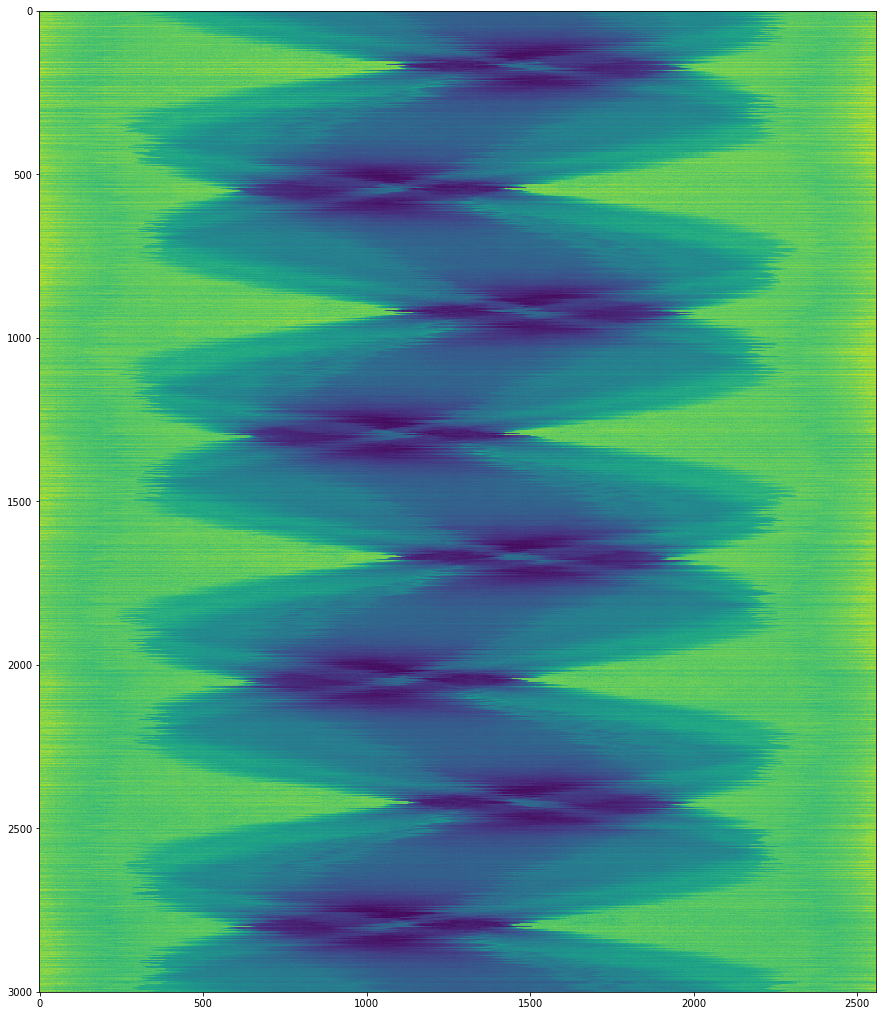

In [ ]:
plt.figure(figsize=(15, 20))
plt.imshow(sino_raw)

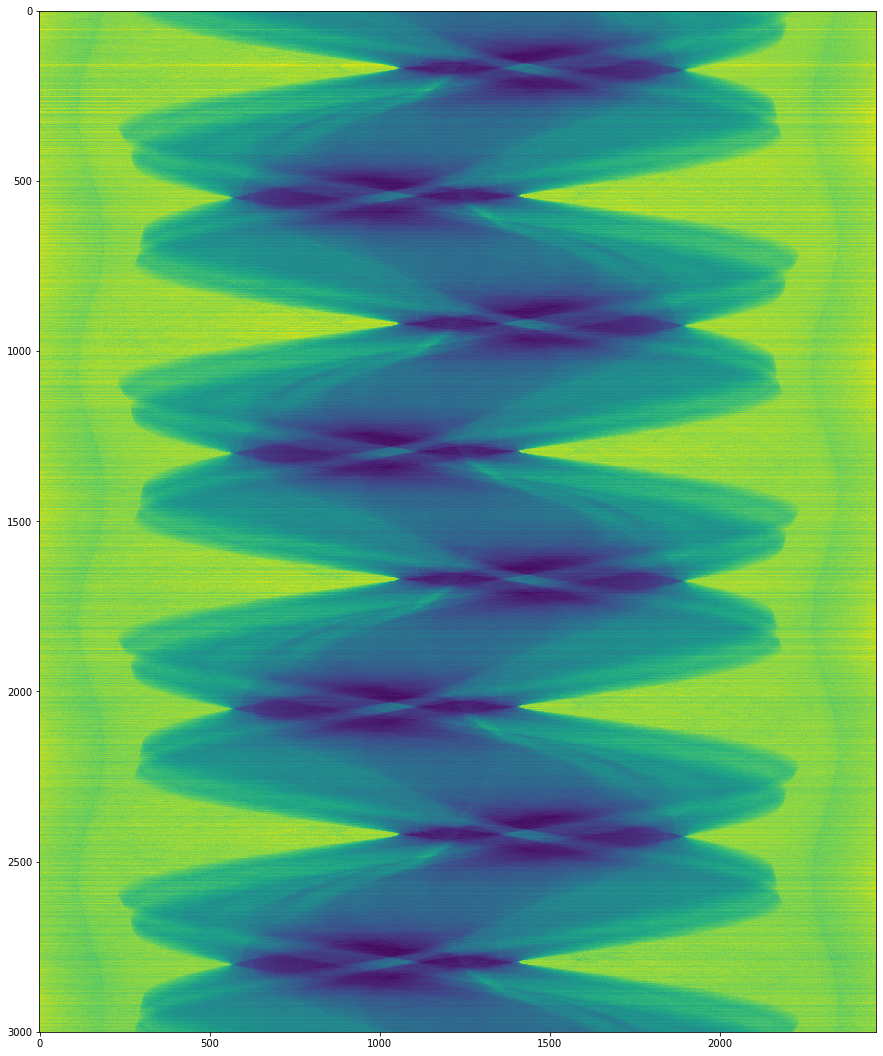

In [ ]:
sino_corrected = correct_image(sino_raw, 1.5 * shifts.squeeze(), linear_interpolation=True, kind='cubic')
plt.figure(figsize=(15, 20))
plt.imshow(sino_corrected)

Проверим, зная правильный сдвиг:

In [ ]:
vo_center = sino_corrected.shape[1] / 2 + 2.5
sino_corrected.shape[1] / 2 - vo_center 

-2.5

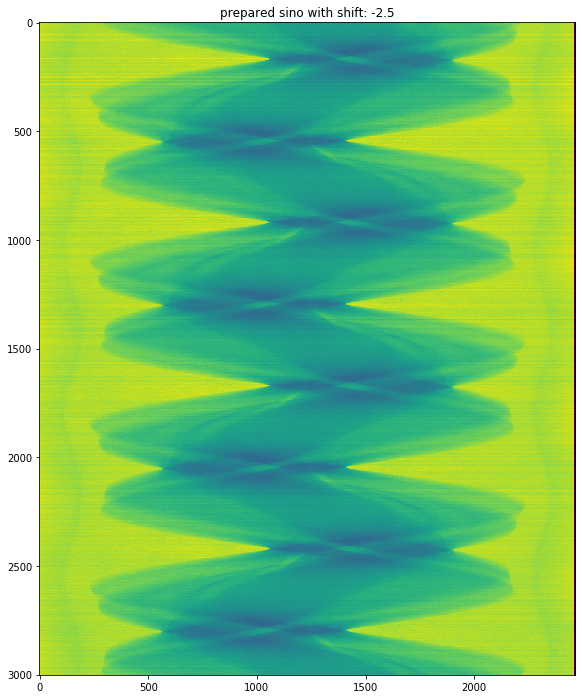

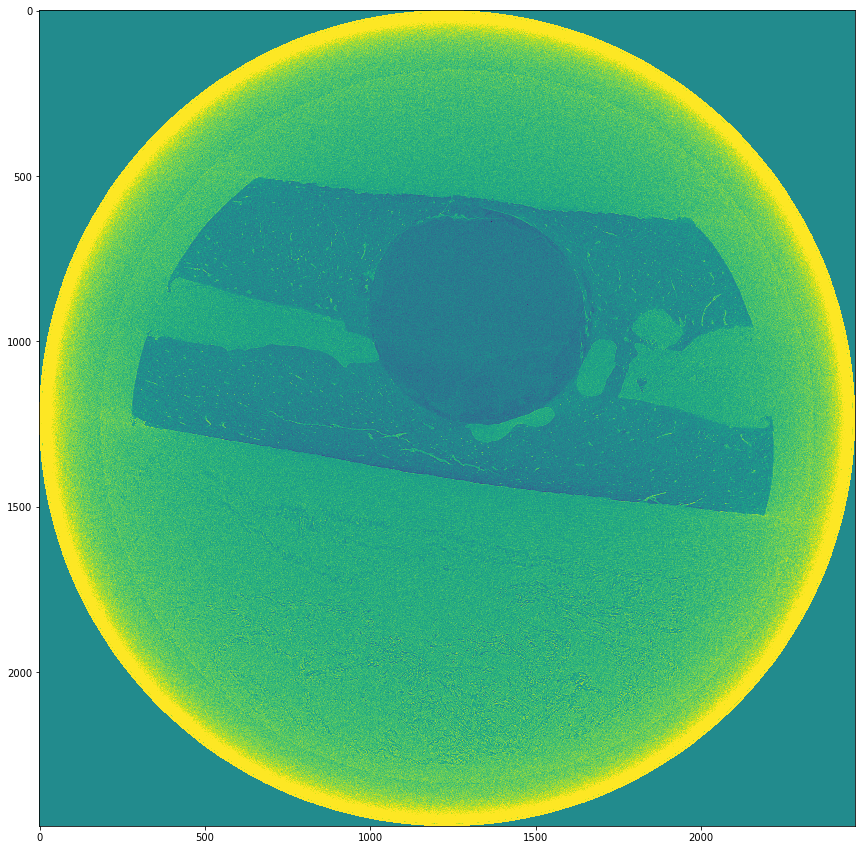

CPU times: user 5min 6s, sys: 720 ms, total: 5min 7s
Wall time: 5min 7s


In [ ]:
%%time
reco = iradon_centered(sino_corrected, angles.squeeze(), vo_center, show=True)

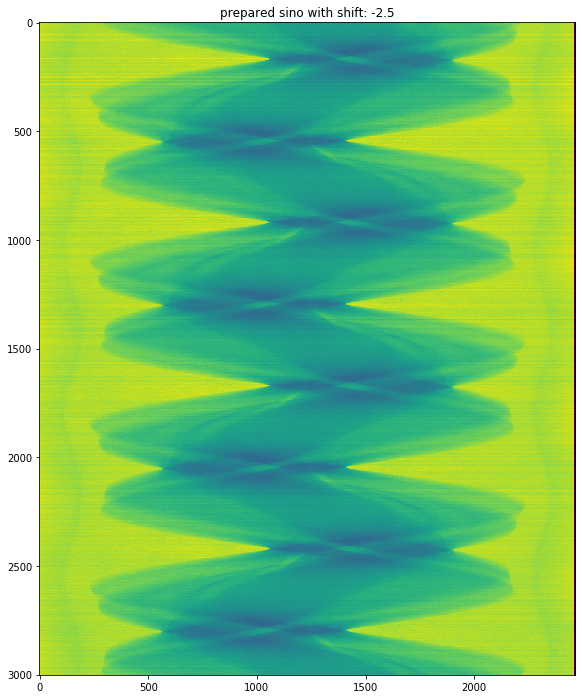

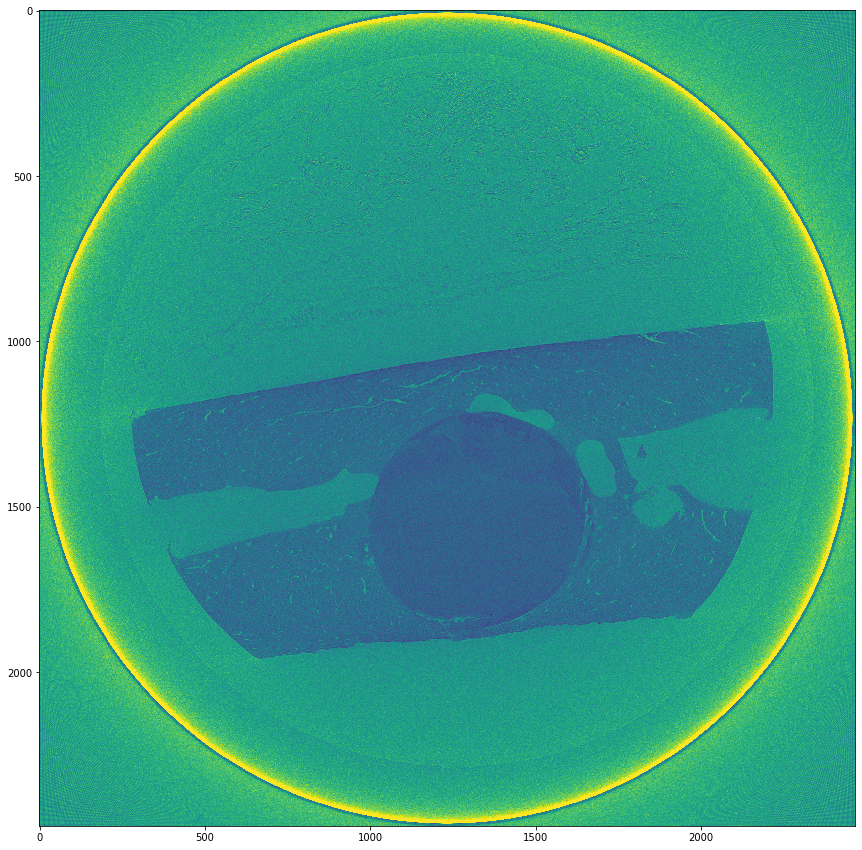

CPU times: user 5min 12s, sys: 1.7 s, total: 5min 14s
Wall time: 5min 14s


In [ ]:
%%time
reco = iradon_centered(sino_corrected, angles.squeeze(), vo_center, show=True, lib='radontea')

## Massive Tests

In [ ]:
from tests import *

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [06:08<00:00, 30.44s/it]


mean: -2.8125 std: 1.7503719842745808


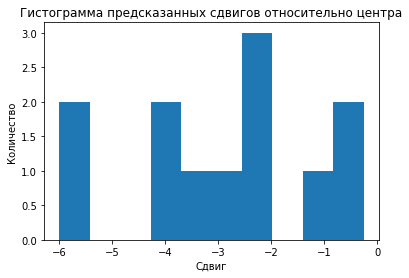

array([1235.5 , 1232.  , 1236.  , 1234.  , 1230.75, 1233.5 , 1231.  ,
       1234.  , 1230.25, 1232.  , 1232.  , 1232.75])

In [75]:
test_rotations(find_center_vo, sino_corrected, angles)

100%|██████████| 12/12 [07:27<00:00, 34.74s/it]


mean: -2.9166666666666665 std: 0.49300664859163473


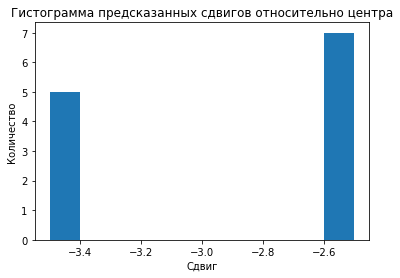

array([1233.5, 1232.5, 1232.5, 1233.5, 1232.5, 1233.5, 1233.5, 1232.5,
       1232.5, 1232.5, 1233.5, 1232.5])

In [76]:
test_crops_flips(find_center_vo, sino_corrected, angles) # small crops

100%|██████████| 12/12 [06:46<00:00, 32.31s/it]


mean: -5.166666666666667 std: 4.159994658116228


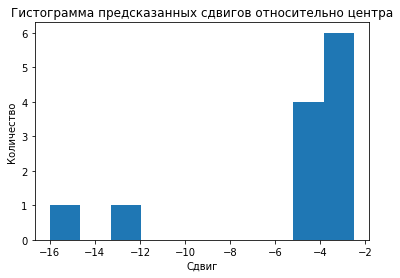

array([1246. , 1233. , 1232.5, 1234. , 1234. , 1233. , 1232.5, 1233.5,
       1234. , 1234. , 1233. , 1242.5])

In [78]:
test_crops_flips(find_center_vo, sino_corrected, angles, crop_right = 0.05, crop_left = 0.05) # big crops

100%|██████████| 12/12 [08:25<00:00, 42.11s/it]


mean: -4.229166666666667 std: 1.4841465467473967


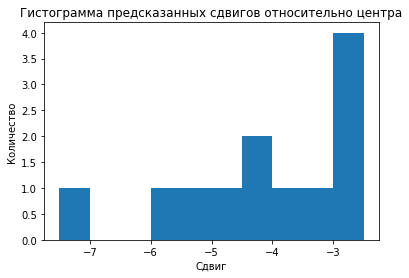

array([1232.75, 1232.75, 1232.5 , 1236.  , 1232.75, 1237.5 , 1234.5 ,
       1235.  , 1235.5 , 1233.5 , 1234.25, 1233.75])

In [77]:
hard_test(find_center_vo, sino_corrected, angles) # combine everything

## Massive test by hand:

### Поиграемся с углами

In [ ]:
from tomopy.recon.rotation import find_center_vo, find_center_pc

In [ ]:
from collections.abc import Iterable

def prepare_slices(sino, angles, shifts=0, n_turns=8):
    '''
    Prepare slices of sinogram for testing Vo's method
     :param sino: prepared sinogram
     :param angles: angles of taken sinogram
     :param shifts: int or array of shifts of angles from halfturn
     :param n_turns: number of rotations of sinogram
     
     :return: prepared sino slices
    '''
    if not isinstance(shifts, Iterable):
        shifts = [shifts] * n_turns
    sino_slices = []
    for i in range(n_turns):
        if shifts[i] > 0 and i == n_turns - 1: continue  # skip not full sized 
        if shifts[i] < 0 and i == 0: continue             # skip not full sized 
        mask = ((i * np.pi + shifts[i] < angles.squeeze()) & (angles.squeeze() < (i + 1) * np.pi + shifts[i]))
        sino_slices.append(sino_corrected[mask])
    min_len = min(len(slice_) for slice_ in sino_slices)
    sino_slices = np.array([sino_slice[:min_len] for sino_slice in sino_slices]).transpose(1, 0, 2)
    return sino_slices

In [ ]:
from tqdm import tqdm

In [ ]:
n_experiments = 12

In [ ]:
vo_centers = []
for i in tqdm(range(n_experiments)):
    shifts = np.random.uniform(-np.pi * 1 / 2, np.pi * 1 / 2, size=8)
    sino_slices = prepare_slices(sino_corrected, angles, shifts)
    vo_centers.append(find_center_vo(sino_slices))
vo_centers = np.array(vo_centers)

100%|██████████| 12/12 [05:48<00:00, 28.73s/it]


In [ ]:
%%time
sino_slices_real = prepare_slices(sino_corrected, angles)
vo_center = find_center_vo(sino_slices_real)

CPU times: user 27.7 s, sys: 134 ms, total: 27.8 s
Wall time: 27.9 s


In [ ]:
sino_corrected.shape[1] / 2 - vo_center

-2.5

In [ ]:
vo_centers

array([1234.5 , 1232.5 , 1229.75, 1237.5 , 1235.  , 1232.25, 1230.25,
       1233.  , 1235.5 , 1232.5 , 1232.  , 1235.  ])

In [ ]:
np.mean(sino_corrected.shape[1] / 2 - vo_centers)

-3.3125

In [ ]:
np.std(sino_corrected.shape[1] / 2 - vo_centers)

2.1557215536025676

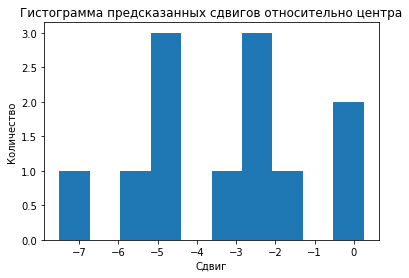

In [ ]:
plt.hist(sino_corrected.shape[1] / 2 - vo_centers)
plt.title("Гистограмма предсказанных сдвигов относительно центра")
plt.xlabel('Сдвиг')
plt.ylabel('Количество')
plt.show()

### Покропаем с большим кропом

In [ ]:
crop_right = crop_left = 0.05

In [ ]:
vo_centers = []
for i in tqdm(range(n_experiments)):
    shift_left = np.random.uniform(0, crop_left)
    shift_right = np.random.uniform(0, crop_right)
    sino_cropped = sino_corrected[:, int(shift_left * sino_corrected.shape[1]):int((1 - shift_right) * sino_corrected.shape[1])]
    sino_slices = prepare_slices(sino_cropped, angles)
    vo_centers.append(find_center_vo(sino_slices) + int(shift_left * sino_corrected.shape[1]))
vo_centers = np.array(vo_centers)

100%|██████████| 12/12 [03:36<00:00, 18.07s/it]


In [ ]:
vo_centers

array([1288.5, 1243.5, 1341.5, 1336.5, 1292.5, 1328.5, 1278.5, 1308.5,
       1257.5, 1313.5, 1237.5, 1329.5])

In [ ]:
np.mean(sino_corrected.shape[1] / 2 - vo_centers), np.std(sino_corrected.shape[1] / 2 - vo_centers)

(-66.33333333333333, 34.62377153857672)

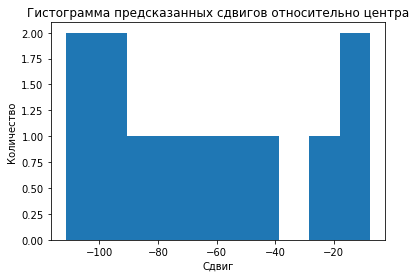

In [ ]:
plt.hist(sino_corrected.shape[1] / 2 - vo_centers)
plt.title("Гистограмма предсказанных сдвигов относительно центра")
plt.xlabel('Сдвиг')
plt.ylabel('Количество')
plt.show()

## покропаем с меньшим кропом (буквально ~10 пикселей)

In [ ]:
crop_right = crop_left = 0.005

In [ ]:
0.005 * sino_corrected.shape[1]

12.3

In [ ]:
vo_centers = []
for i in tqdm(range(n_experiments)):
    shift_left = np.random.uniform(0, crop_left)
    shift_right = np.random.uniform(0, crop_right)
    sino_cropped = sino_corrected[:, int(shift_left * sino_corrected.shape[1]):int((1 - shift_right) * sino_corrected.shape[1])]
    sino_slices = prepare_slices(sino_cropped, angles)
    vo_centers.append(find_center_vo(sino_slices) + int(shift_left * sino_corrected.shape[1]))
vo_centers = np.array(vo_centers)

100%|██████████| 12/12 [03:42<00:00, 18.54s/it]


In [ ]:
vo_centers

array([1242.5, 1243.5, 1236.5, 1243.5, 1233.5, 1244.5, 1232.5, 1241.5,
       1239.5, 1233.5, 1233.5, 1235.5])

In [ ]:
np.mean(sino_corrected.shape[1] / 2 - vo_centers), np.std(sino_corrected.shape[1] / 2 - vo_centers)

(-8.333333333333334, 4.431578600102777)

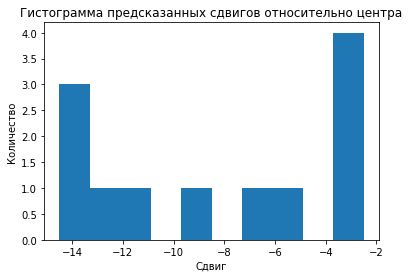

In [ ]:
plt.hist(sino_corrected.shape[1] / 2 - vo_centers)
plt.title("Гистограмма предсказанных сдвигов относительно центра")
plt.xlabel('Сдвиг')
plt.ylabel('Количество')
plt.show()

## Попробуем кропать чуть-чуть и делать флипы

In [ ]:
crop_right = crop_left = 0.005

In [ ]:
from tqdm import tqdm

In [ ]:
vo_centers = []
for i in tqdm(range(n_experiments)):
    shift_left = np.random.uniform(0, crop_left)
    shift_right = np.random.uniform(0, crop_right)
    sino_cropped = sino_corrected[:, int(shift_left * sino_corrected.shape[1]):int((1 - shift_right) * sino_corrected.shape[1])]
    result_transform = lambda x: x + int(shift_left * sino_corrected.shape[1])
    if np.random.rand() > 0.5:
        sino_cropped = sino_cropped[:, ::-1]
        result_transform = lambda x: sino_cropped.shape[1] - x + int(shift_left * sino_corrected.shape[1])
    sino_slices = prepare_slices(sino_cropped, angles)
    vo_centers.append(result_transform(find_center_vo(sino_slices)))
vo_centers = np.array(vo_centers)

100%|██████████| 12/12 [05:24<00:00, 26.87s/it]


In [ ]:
vo_centers

array([1220.5, 1242.5, 1239.5, 1240.5, 1241.5, 1243.5, 1215.5, 1232.5,
       1241.5, 1226.5, 1239.5, 1219.5])

In [ ]:
np.mean(sino_corrected.shape[1] / 2 - vo_centers), np.std(sino_corrected.shape[1] / 2 - vo_centers)

(-3.5833333333333335, 9.869636377406323)

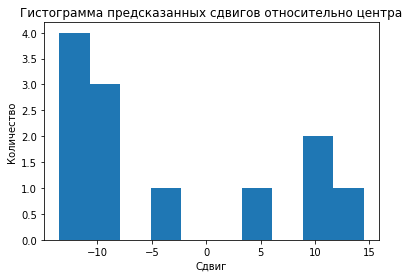

In [ ]:
plt.hist(sino_corrected.shape[1] / 2 - vo_centers)
plt.title("Гистограмма предсказанных сдвигов относительно центра")
plt.xlabel('Сдвиг')
plt.ylabel('Количество')
plt.show()

## Совместим

In [ ]:
vo_centers = []
for i in tqdm(range(n_experiments)):
    shift_left = np.random.uniform(0, crop_left)
    shift_right = np.random.uniform(0, crop_right)
    sino_cropped = sino_corrected[:, int(shift_left * sino_corrected.shape[1]):int((1 - shift_right) * sino_corrected.shape[1])]
    
    shifts = np.random.uniform(-np.pi * 1 / 2, np.pi * 1 / 2, size=8)
    sino_slices = prepare_slices(sino_cropped, angles, shifts)
    vo_centers.append(find_center_vo(sino_slices) + int(shift_left * sino_corrected.shape[1]))
vo_centers = np.array(vo_centers)

100%|██████████| 12/12 [04:04<00:00, 20.36s/it]


In [ ]:
vo_centers

array([1244.  , 1241.  , 1240.  , 1236.5 , 1238.75, 1243.  , 1246.  ,
       1240.5 , 1236.5 , 1244.  , 1244.  , 1236.  ])

In [ ]:
np.mean(sino_corrected.shape[1] / 2 - vo_centers), np.std(sino_corrected.shape[1] / 2 - vo_centers)

(-10.854166666666666, 3.260333465392084)

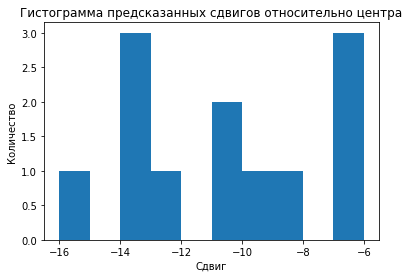

In [ ]:
plt.hist(sino_corrected.shape[1] / 2 - vo_centers)
plt.title("Гистограмма предсказанных сдвигов относительно центра")
plt.xlabel('Сдвиг')
plt.ylabel('Количество')
plt.show()